In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, '../..')

%matplotlib inline
sns.set()

In [41]:
from collections import namedtuple

Y = namedtuple('Y', ['mu', 'std', 'c_l', 'c_u'])
Keys = ['loss', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape']

In [42]:
import glob

In [43]:
dataset = 'nasdaq.csv'

In [44]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')

In [45]:
no_kaf = glob.glob(f'../../logs/{dataset}/darnn_0_0/*/*')[0]
kaf_time = glob.glob(f'../../logs/{dataset}/darnn_0_1/*/*')[0]
kaf_input = glob.glob(f'../../logs/{dataset}/darnn_1_0/*/*')[0]
kaf_dual = glob.glob(f'../../logs/{dataset}/darnn_1_1/*/*')[0]
seq2seq = glob.glob(f'../../logs/{dataset}/seq2seq_1_1/*/*')[0]

In [46]:
def get_ci(x, z=1.96):
    if x.ndim == 2:
        n = x.shape[1]
        mu = x.mean(axis=1)
        std = x.std(axis=1)
    else:
        n = x.shape[0]
        mu = x.mean()
        std = x.std()
        
    c_l, c_u = (mu - z * std/np.sqrt(n), mu + z * std/np.sqrt(n))
    return mu, std, c_l, c_u

In [47]:
def get_train_results(path, key='mae', z=1.96):
    return Y(*get_ci(pd.concat([pd.read_csv(x+'/train/results.csv')[key] for x in path], axis=1), z=z))

In [48]:
df_no_kaf = pd.read_csv(no_kaf + '/train/results.csv')
df_kaf_time = pd.read_csv(kaf_time + '/train/results.csv')
df_kaf_input = pd.read_csv(kaf_input + '/train/results.csv')
df_kaf_dual = pd.read_csv(kaf_dual + '/train/results.csv')
df_seq2seq = pd.read_csv(seq2seq + '/train/results.csv')

In [49]:
def smooth(x,w=0.5):
    p = x[0]
    xs = []
    for d in x:
        p = p * w + (1-w) * d
        xs.append(p)
    return np.array(xs)

In [50]:
df_no_kaf.head()

,loss,norm,mse,mae,smape,rmse,mape
0,1.705275,1.700454,2.912492,1.705275,1.866813,1.705275,99.373314
1,0.094179,1.209442,0.014113,0.094179,0.244225,0.094179,81.064240
2,0.022711,3.286779,0.000950,0.022711,0.032066,0.022711,3.558325
3,0.029098,4.732232,0.001187,0.029098,0.096993,0.029098,29.740482
4,0.055680,0.204154,0.005369,0.055680,0.166202,0.055680,480.724487


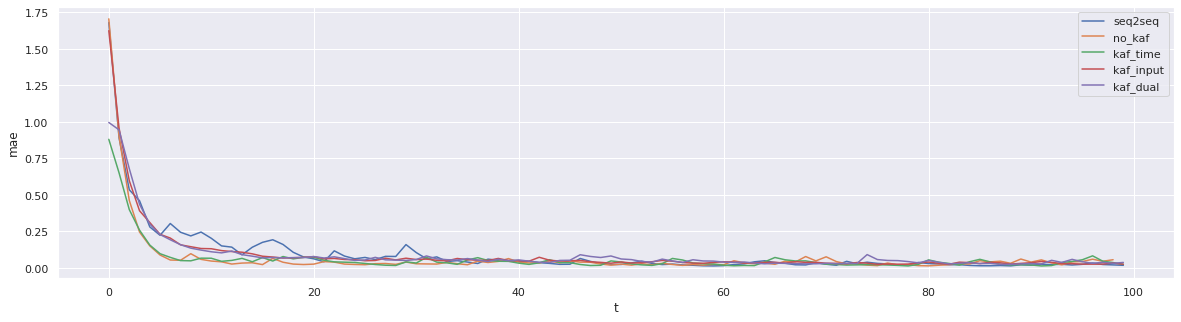

In [11]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

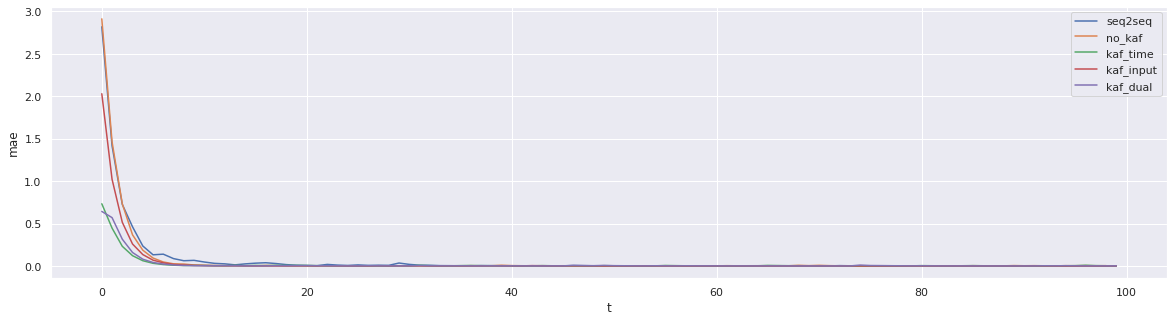

In [12]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.mse.values))
ax.plot(smooth(df_no_kaf.mse.values))
ax.plot(smooth(df_kaf_time.mse.values))
ax.plot(smooth(df_kaf_input.mse.values))
ax.plot(smooth(df_kaf_dual.mse.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [13]:
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))

In [14]:
# no reg
rows = ['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual']

table = pd.concat([df_seq2seq.mean(axis=0),
                   df_no_kaf.mean(axis=0), 
                   df_kaf_time.mean(axis=0), 
                   df_kaf_input.mean(axis=0), 
                   df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.078239,0.003160,1.828866,0.038459,0.075079,0.109258,0.075079,302.274532
no_kaf,0.052235,0.000000,4.044785,0.031789,0.052235,0.077321,0.052235,32.028446
kaf_time,0.051821,0.001682,6.608822,0.011633,0.050139,0.094407,0.050139,101.894040
kaf_input,0.073786,0.030206,4.994623,0.021929,0.043580,0.067019,0.043580,20.188895
kaf_dual,0.078173,0.032508,5.485382,0.013737,0.045665,0.064594,0.045665,20.519316


In [15]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.017814,0.000332,0.151009,0.028214,0.017701,0.021258,0.017701,259.847715
no_kaf,0.017075,0.000000,0.239656,0.029397,0.017075,0.019232,0.017075,7.272547
kaf_time,0.009691,0.000448,0.398617,0.007463,0.009371,0.022066,0.009371,52.403854
kaf_input,0.016368,0.003706,0.306732,0.020284,0.014040,0.018505,0.014040,3.554941
kaf_dual,0.013450,0.004113,0.327084,0.008079,0.010269,0.017971,0.010269,3.985053


In [16]:
table.index

Index(['loss', 'reg', 'norm', 'mse', 'mae', 'smape', 'rmse', 'mape'], dtype='object')

In [17]:
header = table.index.tolist()

In [18]:
df_no_kaf = pd.read_csv(no_kaf + '/test/results.csv', header=None)
df_no_kaf.insert(1, 'reg', value=np.zeros(len(df_no_kaf)))
df_no_kaf.columns = header

In [19]:
df_seq2seq = pd.read_csv(seq2seq+ '/test/results.csv', names=header)
df_kaf_time = pd.read_csv(kaf_time + '/test/results.csv', names=header)
df_kaf_input = pd.read_csv(kaf_input + '/test/results.csv', names=header)
df_kaf_dual = pd.read_csv(kaf_dual+ '/test/results.csv', names=header)

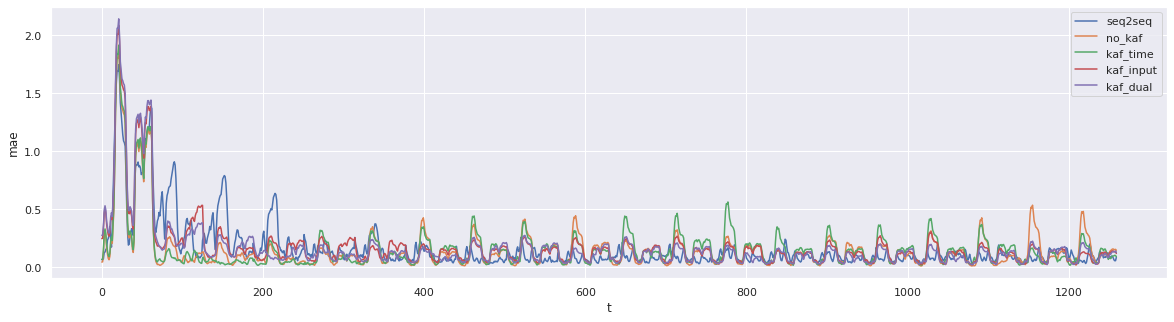

In [20]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(smooth(df_seq2seq.loss.values))
ax.plot(smooth(df_no_kaf.loss.values))
ax.plot(smooth(df_kaf_time.loss.values))
ax.plot(smooth(df_kaf_input.loss.values))
ax.plot(smooth(df_kaf_dual.loss.values))
plt.ylabel('mae')
plt.xlabel('t')
plt.legend(['seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [21]:
table = pd.concat([
                    df_seq2seq.mean(axis=0),
                    df_no_kaf.mean(axis=0), 
                    df_kaf_time.mean(axis=0), 
                    df_kaf_input.mean(axis=0), 
                    df_kaf_dual.mean(axis=0),
                  ], axis=1)
table.columns = rows

In [22]:
# no reg
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.162867,0.006853,3.299145,0.079289,0.156014,0.231505,0.156014,183.771410
no_kaf,0.151364,0.000000,5.208815,0.074514,0.151364,0.186009,0.151364,56.529872
kaf_time,0.160400,0.002256,8.026850,0.078929,0.158145,0.198606,0.158145,79.883349
kaf_input,0.176605,0.034608,6.846134,0.068784,0.141997,0.179551,0.141997,44.559507
kaf_dual,0.165533,0.037469,6.554569,0.065568,0.128064,0.165579,0.128064,49.370201


In [23]:
table = pd.concat([
                    df_seq2seq.std(axis=0)/np.sqrt(len(df_seq2seq)),
                    df_no_kaf.std(axis=0)/np.sqrt(len(df_no_kaf)), 
                    df_kaf_time.std(axis=0)/np.sqrt(len(df_kaf_time)), 
                    df_kaf_input.std(axis=0)/np.sqrt(len(df_kaf_input)), 
                    df_kaf_dual.std(axis=0)/np.sqrt(len(df_kaf_dual)),
                  ], axis=1)
table.columns = rows

# +/- z * std/sqrt(N)
table.T

,loss,reg,norm,mse,mae,smape,rmse,mape
seq2seq,0.006406,0.000077,0.039735,0.008164,0.006380,0.008984,0.006380,24.376533
no_kaf,0.006169,0.000000,0.059737,0.008843,0.006169,0.008614,0.006169,4.159367
kaf_time,0.006350,0.000164,0.095808,0.008943,0.006255,0.008691,0.006255,7.302854
kaf_input,0.006882,0.001290,0.080614,0.008837,0.005968,0.008655,0.005968,3.189243
kaf_dual,0.007084,0.001443,0.074620,0.009145,0.006044,0.008825,0.006044,4.590826


In [126]:
def last_path(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    idx = max(idxs)
    return base_path + '/report/' + ''.join([str(idx), '_', 'report.csv'])

In [127]:
df_no_kaf = pd.read_csv(last_path(no_kaf), index_col=0)
# df_dense = pd.read_csv(last_path(dense), index_col=0)
df_seq2seq = pd.read_csv(last_path(seq2seq), index_col=0)
df_kaf_time = pd.read_csv(last_path(kaf_time), index_col=0)
df_kaf_input = pd.read_csv(last_path(kaf_input), index_col=0)
df_kaf_dual = pd.read_csv(last_path(kaf_dual), index_col=0)

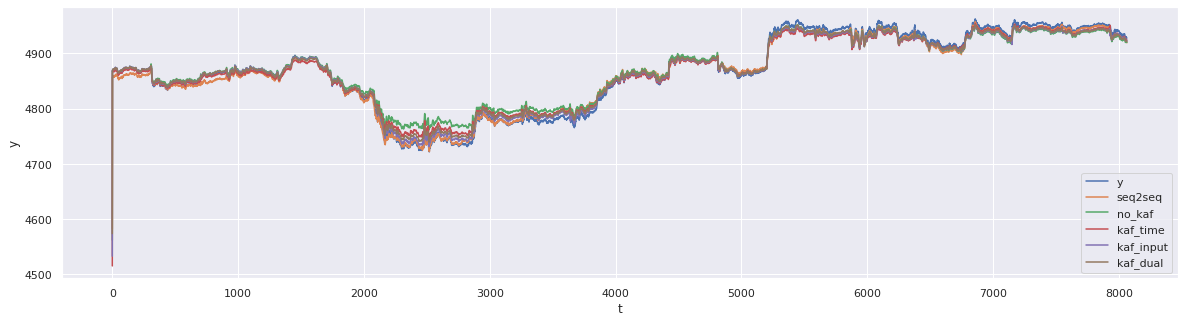

In [128]:
fig,ax = plt.subplots(1,1, figsize=(20,5))
ax.plot(df_no_kaf.y.values)
ax.plot(df_seq2seq.y_hat.values)
ax.plot(df_no_kaf.y_hat.values)
# ax.plot(df_dense.y_hat.values)
ax.plot(df_kaf_time.y_hat.values)
ax.plot(df_kaf_input.y_hat.values)
ax.plot(df_kaf_dual.y_hat.values)
plt.ylabel('y')
plt.xlabel('t')
plt.legend(['y',
            'seq2seq','no_kaf','kaf_time','kaf_input', 'kaf_dual'])

In [129]:
from ntsa.utils.misc import regr_metrics

In [130]:
y = df_no_kaf.y.values
y_seq2seq = df_seq2seq.y_hat.values
y_no_kaf = df_no_kaf.y_hat.values
y_kaf_time = df_kaf_time.y_hat.values
y_kaf_input = df_kaf_input.y_hat.values
y_kaf_dual = df_kaf_dual.y_hat.values

metrics = [
list(regr_metrics(y, y_seq2seq).values()),
list(regr_metrics(y, y_no_kaf).values()),
list(regr_metrics(y, y_kaf_time).values()),
list(regr_metrics(y, y_kaf_input).values()),
list(regr_metrics(y, y_kaf_dual).values())
]

In [131]:
pd.DataFrame(np.array(metrics), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,55.568605,5.621290,0.001154,0.000577,0.987907,0.115458
no_kaf,190.078321,9.970078,0.002063,0.001023,0.958635,0.206024
time,101.362106,7.369221,0.001521,0.000757,0.977941,0.152036
input,53.464018,5.401353,0.001109,0.000555,0.988365,0.110988
dual,64.230617,6.090048,0.001255,0.000625,0.986022,0.125534


In [140]:
def get_test_metrics(base_path):
    paths = glob.glob(base_path + '/report/*.csv')
    idxs = list(map(lambda x: int(x.split('/')[-1].split('_')[0]), paths))
    data  = {}
    for p,idx in zip(paths, idxs):
        data[idx] = pd.read_csv(p, index_col=0)
    data = collections.OrderedDict(sorted(data.items()))
    m = {}
    for k, v in data.items():
        m[k] = list(regr_metrics(v.y.values,v.y_hat.values).values())
    return np.array(list(m.values()))

In [141]:
table = [get_test_metrics(seq2seq).mean(axis=0),
get_test_metrics(no_kaf).mean(axis=0),
get_test_metrics(kaf_time).mean(axis=0),
get_test_metrics(kaf_input).mean(axis=0),
get_test_metrics(kaf_dual).mean(axis=0)]

pd.DataFrame(np.array(table), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,363.481056,10.563274,0.002178,0.001085,0.920898,0.217880
no_kaf,341.592285,10.248442,0.002113,0.001052,0.925662,0.211173
time,361.833558,10.707575,0.002208,0.001100,0.921257,0.220619
input,315.324543,9.614241,0.001978,0.000987,0.931378,0.197747
dual,300.580222,8.670864,0.001784,0.000890,0.934587,0.178340


In [142]:
table = [get_test_metrics(seq2seq).std(axis=0)/np.sqrt(20),
get_test_metrics(no_kaf).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_time).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_input).std(axis=0)/np.sqrt(20),
get_test_metrics(kaf_dual).std(axis=0)/np.sqrt(20)]

pd.DataFrame(np.array(table), index=['seq2seq','no_kaf',
                                       'time', 'input', 'dual'], columns=['mse', 'mae', 'smape','smape2','residual', 'mape'])

,mse,mae,smape,smape2,residual,mape
seq2seq,202.717343,2.535185,0.000522,0.000260,0.044116,0.052207
no_kaf,215.170558,2.315078,0.000476,0.000238,0.046826,0.047518
time,216.605265,2.343661,0.000482,0.000241,0.047138,0.048107
input,216.700686,2.343060,0.000482,0.000241,0.047159,0.048102
dual,225.690030,2.435482,0.000501,0.000250,0.049115,0.050003
